In [1]:
include("Axis_Aligned_Box.jl");
type Mondrian_Node
    parent::Nullable{Mondrian_Node}
    left::Nullable{Mondrian_Node}
    right::Nullable{Mondrian_Node}
    τ::Float64
    node_type::Array{Bool,1}        # node,leaf,root
    δ::Nullable{Int}                # split dimension
    ζ::Nullable{Float64}            # split position
    Θ::Nullable{Axis_Aligned_Box}   # data boxes B
    tab::Array{Int}
    c::Array{Int}
    Gₚ::Array{Float64}
    indices::Array{Int}
end

function Mondrian_Node(τ, node_type, tab, c, Gₚ)
    N = Mondrian_Node(Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      τ,node_type,
                      Nullable{Int}(),
                      Nullable{Float64}(),
                      Nullable{Axis_Aligned_Box}(),
                      tab,
                      c,
                      Gₚ,
                      Array{Int}())
    return N
end

function Mondrian_Node()
    N = Mondrian_Node(Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      0,[true,false,false],
                      Nullable{Int}(),
                      Nullable{Float64}(),
                      Nullable{Axis_Aligned_Box}(),
                      Array{Int}(),
                      Array{Int}(),
                      Array{Float64}(),
                      Array{Int}())
    return N
end

function Mondrian_Node(τ::Float64)
    N = Mondrian_Node(Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      τ,[true,false,false],
                      Nullable{Int}(),
                      Nullable{Float64}(),
                      Nullable{Axis_Aligned_Box}(),
                      Array{Int}(),
                      Array{Int}(),
                      Array{Float64}(),
                      Array{Int}(1))
    return N
end

function Mondrian_Node(τ::Float64, node_type::Array{Bool,1})
    N = Mondrian_Node(Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      Nullable{Mondrian_Node}(),
                      τ,
                      node_type,
                      Nullable{Int}(),
                      Nullable{Float64}(),
                      Nullable{Axis_Aligned_Box}(),
                      Array{Int}(),
                      Array{Int}(),
                      Array{Float64}(),
                      Array{Int}())
    return N
end

type Mondrian_Tree
    root::Nullable{Mondrian_Node}
    leaves::Array{Mondrian_Node,1}
end

function Mondrian_Tree()
    T = Mondrian_Tree(Nullable{Mondrian_Node}(),Array{Mondrian_Node,1}())
end

function Mondrian_Tree(N::Mondrian_Node)
    T = Mondrian_Tree(N,Array{Mondrian_Node,1}())
end

Mondrian_Tree

In [128]:
using Distributions

function Sample_Mondrian_Tree(λ,D)
    δ = []
    ζ = []
    n = 1:size(D,1)
    e = Mondrian_Node(0.0,[false,false,true])
    T = Mondrian_Tree(e)
    Θ = Axis_Aligned_Box(get_intervals(D[1]))
    e.Θ = Θ
    e.tab = zeros(size(unique(D[2]),1))
    e.c = zeros(size(unique(D[2]),1))
    e.Gₚ = zeros(size(unique(D[2]),1))
    k=[0]
    Sample_Mondrian_Block(e, Θ, λ, δ, ζ, T, D[1],k)
    println(k)
    return T
end

function Sample_Mondrian_Block(j, Θ, λ, δ, ζ, tree, Data,k)
    k[1] += 1
    E = rand(Exponential(1/Linear_dimension(Θ)))
#     j.left = Mondrian_Node(0,[false,false,false],[0,0],[0,0],[0,0])
#     j.right = Mondrian_Node(0,[false,false,false],[0,0],[0,0],[0,0])
#     get(j.left).parent = j
#     get(j.right).parent = j
#     get(j.left).Θ=copy(Θ)
#     get(j.right).Θ=copy(Θ)
    
    if j.node_type[3]==true
        τₚ = 0
    else
        τₚ = (get(j.parent)).τ
    end
    if τₚ + E < λ
        d,x = sample_split_dimension(Θ)
        j.δ = d
        j.ζ = x
        j.τ = τₚ+E
        Θᴸ = Θ
        # look at this copy
        Θᴿ = copy(Θ)
        Θᴸ.Intervals[d,2]=x
        Θᴿ.Intervals[d,1]=x+1e-6
        Dᴿ = get_data_indices(Θᴿ,Data)
        Dᴸ = get_data_indices(Θᴸ,Data)
        if (size(Dᴿ,1)>0 && size(Dᴸ,1)>0)
            right = Mondrian_Node(0.0, [true,false,false])
            right.parent = j
            right.Θ = Axis_Aligned_Box(get_intervals(Data[Dᴿ,:]))
            right.tab = zeros(size(j.tab))
            right.c = zeros(size(j.tab))
            right.Gₚ=zeros(size(j.c,1))
            j.right = right
            left = Mondrian_Node(0.0, [true,false,false])
            left.parent = j
            left.Θ = Axis_Aligned_Box(get_intervals(Data[Dᴸ,:]))
            left.tab = zeros(size(j.tab))
            left.c = zeros(size(j.tab))
            left.Gₚ = zeros(size(j.c,1))
            j.left = left
            Sample_Mondrian_Block(left, Θᴸ, λ, δ, ζ, tree, Data[Dᴸ,:],k)
            Sample_Mondrian_Block(right,Θᴿ,λ, δ, ζ, tree, Data[Dᴿ,:],k)
        
        else
            j.τ = λ
            j.node_type = [false,true,false]
            push!(tree.leaves,j)
            return
        end 
    else
        j.τ = λ
        j.node_type = [false,true,false]
        push!(tree.leaves,j)
        return
    end
end

function get_data_indices(Θ::Axis_Aligned_Box, D::Array{Float64,2})
    indices = []
    include = false
    for i in 1:size(D,1)
        for j in 1:size(Θ.Intervals,1)
            if (D[i,j] < Θ.Intervals[j,1] || D[i,j] > Θ.Intervals[j,2])
                include = false
                break
            end
            include = true
        end
        if (include)    
            push!(indices, i)
        end
    end
    return indices
end

function set_label_distribution!(j,Θ, D)
    indices = get_data_indices(Θ, D)
    if length(indices)>0
        for k in 1:length(unique(D[2]))
            j.Gₚ = length(D[2][D[2].==k])
        end
        j.Gₚ = j.Gₚ/(sum(j.Gₚ))
    end
end

function initialize_posterior_leaf_counts!(Tree, D)
    X = D[1]
    Y = D[2]
    for leaf in Tree.leaves
        indices = get_data_indices(get(leaf.Θ),X)
        if length(indices)>0
            y = Y[indices]
            for k in 1:length(leaf.c)
                leaf.c[k] = length(y[y.==k])
                leaf.tab[k] = min(leaf.c[k],1)
            end
        end
    end
end

function initialize_posterior_counts!(Tree,D)
    initialize_posterior_leaf_counts!(Tree,D)
    for leaf in Tree.leaves
        j = leaf
        while true
            if j.node_type[2]==false
                for k in 1:length(j.c)
                    j.c[k] = get(j.left).tab[k]+get(j.right).tab[k]
                end
            end
            for k in 1:length(j.c)
                j.tab[k] = min(j.c[k],1)
            end
            if j.node_type[3]==true
                break
            else
                j = get(j.parent)
            end
        end
    end
end

function update_posterior_counts!(leaf,y)
    leaf.c[y] += 1
    l = leaf
    while true
        if l.tab[y] == 1
            return
        else
            if l.node_type[2] == false
                l.c[y] = get(l.left).tab[y]+get(l.right).tab[y]
            end
            l.tab[y] = min(l.c[y],1)
            if l.node_type[3] == true
                return
            else
                l = get(l.parent)
            end
        end
    end         
end

function update_posterior_counts_batch!(Tree,D)
    for leaf in Tree.leaves
        indices = get_data_indices(get(leaf.Θ),D[1])
        for y in D[2][indices,:]
            update_posterior_counts(leaf,y)
        end
    end
end

function compute_predictive_posterior_distribution!(Tree, γ=1)
    J = [get(Tree.root)]
    while (size(J,1) != 0)
        j = shift!(J)
        if (j.node_type[3]==true)
            p = ones(length(j.c))./length(j.c)
            d = exp(-γ*(j.τ))
        else 
            d = exp(-γ*(j.τ-get(j.parent).τ))
            p = get(j.parent).Gₚ
        end
        for k in 1:length(j.c)
            j.Gₚ[k] = (1/(sum(j.c)+1))*(j.c[k]-d*j.tab[k]+sum(j.tab)*p[k])
        end
        if sum(j.node_type)==0
            break
        end
        if j.node_type[2] == false 
            push!(J, get(j.left))
            push!(J, get(j.right))
        end
    end
end

function expected_discount(nⱼ, Δⱼ,γ=1)
    Δ = rand(Truncated(Exponential(1/nⱼ),0,Δⱼ),10000)
    return mean(exp.(-γ*Δ))
end

function predict!(T,x, γ=1)
    j = get(T.root)
    not_sep = 1
    s = zeros(size(j.c,1))
    while true
        if (sum(j.node_type)==0)
            break
        end
        if (j.node_type[3] == true)
            Δⱼ = j.τ
        else
            Δⱼ = j.τ - get(j.parent).τ
        end
        nⱼ=0
        for d in size(x,1)
            nⱼ += max(x[d]-get(j.Θ).Intervals[d,2],0) + max(get(j.Θ).Intervals[d,1]-x[d],0)
        end
        pⱼ = 1-exp(Δⱼ*nⱼ)
        if pⱼ > 0
            println("Yes")
            # x branches
            jₓ = Mondrian_Node()
            if (j == get(j.parent).left)
                get(j.parent).left = jₓ
            else
                get(j.parent).right = jₓ
            end
            jₓ.parent = get(j.parent)
            j.parent = jₓ
            jₓ.left = j
            jₓ.right = Mondrian_Node()
            d = expected_discount(nⱼ, Δⱼ, γ)
            for k in 1:length(j.c)
                jₓ.c[k] = min(j.c[k],1)
            end
            jₓ.tab = jₓ.c
            for k in 1:length(jₓ.c)
                jₓ.Gₚ[k] = 1/(sum(jₓ.c)+1)*(jₓ.c[k] - d*jₓ.tab[k]+d*sum(jₓ.tab)*get(jₓ.parent).Gₚ[k])
            end
            for k in 1:length(s)
                s[k] += not_sep*(1-pⱼ)*jₓ.Gₚ[k]
            end
        end
        if j.node_type[2] == true
            for k in 1:length(s)
                s[k] += not_sep*(1-pⱼ)*j.Gₚ[k]
            end
            return s
        else
            not_sep = not_sep*(1-pⱼ)
            if x[get(j.δ)] <= get(j.ζ)
                j = get(j.left)
            else
                j = get(j.right)
            end
        end
    end
end

function depth(Tree::Mondrian_Tree)
    j = Tree.leaves[1]
    d = 0
    while !(j.node_type[3])
        j = get(j.parent)
        d+=1
    end
    return d
end

depth (generic function with 1 method)

In [129]:
using MLBase
function Fakedata(n,dim) 
    x = randn(n,dim)
    y = (sum(exp.(x)/(1+exp.(x)),2)).>0.5
    return 1.0*x,1*y[:,1]
end

d=2
X, Y = Fakedata(1000,d);
D = (X,Y.+1)

x,y = Fakedata(1000,d)
D_test = (x,y.+1)

([-0.052104 -2.03155; 0.692859 0.251897; … ; -1.36148 -1.06672; -0.691905 0.636722], [1, 1, 1, 1, 1, 1, 2, 2, 1, 2  …  2, 1, 1, 1, 2, 1, 1, 2, 1, 1])

In [130]:
t = y.==1;

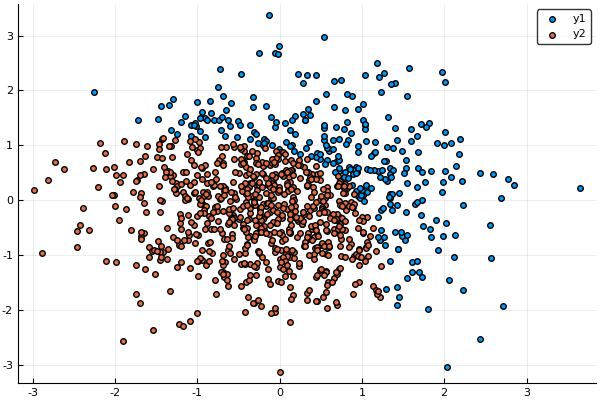

In [131]:
using Plots
scatter(x[t.==1,1],x[t.==1,2])
scatter!(x[t.==0,1],x[t.==0,2])

In [150]:
#Profile.init(delay=0.0001)
@time MT = Sample_Mondrian_Tree(1e9,D);
@time initialize_posterior_counts!(MT,D);
@time compute_predictive_posterior_distribution!(MT,10*size(D[1],2));

pred = []
for i in 1:size(D[1],1) 
    p = predict!(MT,D[1][i,:],10*size(D[1],2))
    if p[1] > p[2]
        push!(pred,1)
    else
        push!(pred,2)
    end
end
println("Train accuracy")
println(correctrate(D[2],convert(Array{Int,1},pred)))
println(unique(pred))

x,y = Fakedata(1000,d)
D_test = (x,y.+1)
pred = []
for i in 1:size(D_test[1],1) 
    p = predict!(MT,D_test[1][i,:],10*size(D_test[1],2))
    if p[1] > p[2]
        push!(pred,1)
    else
        push!(pred,2)
    end
end
println("Test accuracy")
println(correctrate(D_test[2],convert(Array{Int,1},pred)))
println(unique(pred))

[465]
  0.051436 seconds (401.00 k allocations: 9.601 MiB)
  0.071212 seconds (1.31 M allocations: 29.189 MiB, 16.39% gc time)
  0.000700 seconds (6.53 k allocations: 106.438 KiB)
Train accuracy
0.943
[1, 2]
Test accuracy
0.763
[2, 1]


In [151]:
depth(MT)

5

In [152]:
i=0
for l in MT.leaves
    i+=1
end
i

233

In [48]:
function get_data_indices!(Θ::Axis_Aligned_Box, D::Array{Float64,2})
    indices = []
    include = false
    for i in 1:size(D,1)
        for j in 1:size(Θ.Intervals,1)
            if (D[i,j] < Θ.Intervals[j,1] || D[i,j] > Θ.Intervals[j,2])
                include = false
                break
            end
            include = true
        end
        if (include)    
            push!(indices, i)
        end
    end
    return indices
end

get_data_indices! (generic function with 1 method)

In [65]:
function cart(x,y)
    [repeat(x, inner=[size(y,1)]) repeat(y, outer=[size(x,1)])]
end

cart (generic function with 1 method)

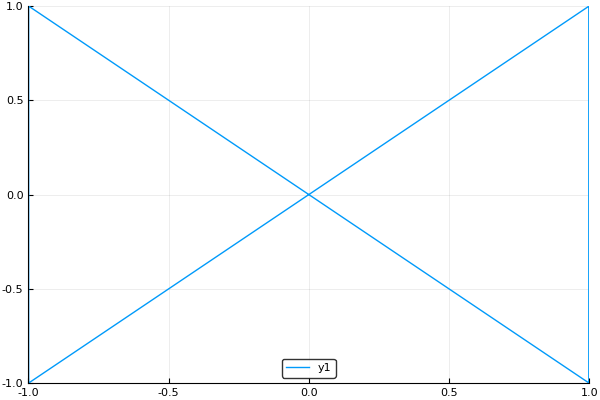

In [286]:
a = [1,-1]
b = [1,-1]
x
x=vcat(cart(a,b),cart(reverse(a),b))
plot(x[:,1],x[:,2])

In [284]:
x[:,1]

8-element Array{Int64,1}:
  1
  1
 -1
 -1
 -1
 -1
  1
  1

In [154]:
function Mondrian_Forest_predict!(D_train,D_pred,λ,nₜ=200)
    trees = Array{Mondrian_Tree}(nₜ)
    pred = Array{Int, 2}(nₜ,size(D_pred,1))
    for i in 1:nₜ
        trees[i] = Sample_Mondrian_Tree(λ,D_train)
        initialize_posterior_counts!(trees[i],D_train);
        compute_predictive_posterior_distribution!(trees[i],10*size(D_train[1],2));
        for j in 1:size(D_pred,1) 
            p = predict!(trees[i],D_pred[j,:],10*size(D_pred,2))
            if p[1] > p[2]
                pred[i,j] = 1
            else
                pred[i,j] = 2
            end
        end
    end
    p = Array{Int,1}(size(D_pred,1))
    for i in 1:size(D_pred,1)
        p[i] = mode(pred[:,i])
    end
    return p, trees
end
# println("Train accuracy")
# p = Mondrian_Forest_predict!(D,D[1],0.3)
# println(correctrate(p,convert(Array{Int,1},D[2])))
@time p,T = Mondrian_Forest_predict!(D,D_test[1],10,100)
println("Test accuracy")
println(correctrate(p,convert(Array{Int,1},D_test[2])))

[309]
[253]
[531]
[511]
[61]
[251]
[501]
[149]
[459]
[495]
[3]
[477]
[347]
[285]
[527]
[493]
[377]
[565]
[527]
[433]
[323]
[547]
[377]
[367]
[423]
[91]
[477]
[513]
[469]
[245]
[519]
[351]
[421]
[505]
[531]
[357]
[475]
[359]
[371]
[309]
[227]
[419]
[479]
[487]
[289]
[455]
[443]
[369]
[393]
[189]
[377]
[527]
[253]
[199]
[435]
[483]
[125]
[609]
[515]
[541]
[293]
[327]
[185]
[511]
[323]
[485]
[587]
[495]
[225]
[381]
[247]
[579]
[563]
[345]
[347]
[107]
[501]
[403]
[337]
[257]
[321]
[507]
[491]
[325]
[439]
[521]
[395]
[427]
[467]
[361]
[405]
[251]
[457]
[393]
[405]
[471]
[485]
[529]
[537]
[519]
 11.476611 seconds (176.20 M allocations: 3.719 GiB, 14.18% gc time)
Test accuracy
0.958


In [9]:
t_test = p.==2;

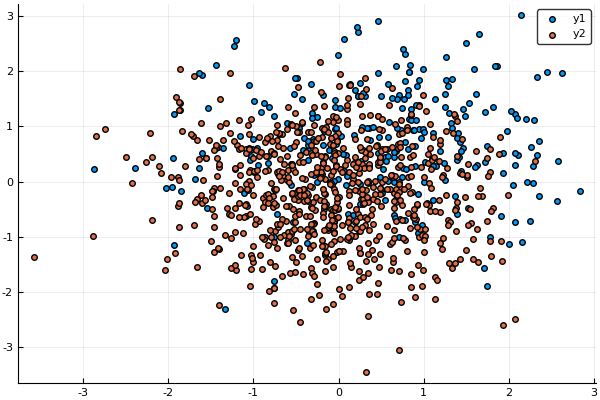

In [10]:
scatter(x[t_test.==1,1],x[t_test.==1,2])
scatter!(x[t_test.==0,1],x[t_test.==0,2])

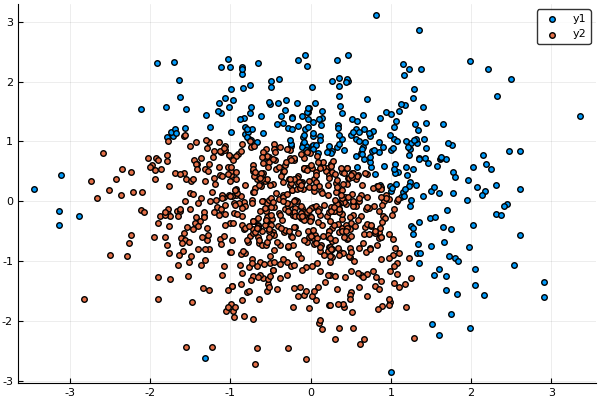

In [130]:
scatter(x[t.==1,1],x[t.==1,2])
scatter!(x[t.==0,1],x[t.==0,2])

In [39]:
x = [1,10,25,50,100]
t = zeros(length(x))
for i in 1:length(x)
    t[i] = (@allocated Mondrian_Forest_predict!(D,D_test[1],0.15,x[i]))
end

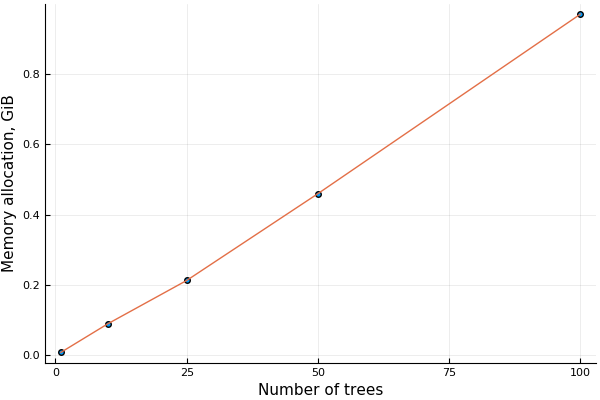

In [40]:
using Plots
scatter(x,t./1e9, label="")
plot!(x,t./1e9, label="")
xlabel!("Number of trees")
ylabel!("Memory allocation, GiB")

In [24]:
using DecisionTree
@time forest = build_forest(Y, X, d, 10)

pred = 1*apply_forest(forest,x)
println("Correct: ", correctrate(y, pred))
println("Error: ", errorrate(y,pred))

  0.128768 seconds (101.77 k allocations: 21.879 MiB, 3.85% gc time)
Correct: 0.873
Error: 0.127


In [104]:
for leaf in MT.leaves
    println(leaf.c)
end

[0, 0]
[0, 0]
[0, 1]
[0, 0]
[38, 0]
[2, 3]
[0, 0]
[6, 5]
[35, 2]
[30, 19]
[0, 0]
[0, 0]
[7, 3]
[394, 182]
[0, 0]
[0, 1]
[0, 1]
[21, 26]
[0, 38]
[1, 45]
[0, 2]
[0, 20]
[0, 25]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 1]
[0, 10]
[0, 0]
[0, 1]
[0, 32]
[0, 0]
[0, 0]
[0, 24]
[0, 3]
[0, 21]
[0, 1]


In [91]:
include("load_titanic.jl")
x_train, y_train, x_test, y_test = load();
D = (x_train, y_train.+1)
D_test = (x_test,y_test.+1)
@time MT = Sample_Mondrian_Tree(0.03,D);
initialize_posterior_counts!(MT,D);
compute_predictive_posterior_distribution!(MT,10*size(D[1],2));

leafL
leaf
leaf
leafR
leaf
leafR
leafL
leaf
leaf
leaf
leafL
leaf
leaf
leafL
leaf
leaf
leafL
leaf
leafL
leaf
leaf
leafR
leaf
leaf
leafR
leafL
leaf
leafR
leaf
leafL
leaf
leaf
leaf
leaf
leaf
leaf
leaf
leaf
leaf
leaf
leaf
leafR
leaf
leaf
leafL
leaf
leafL
leaf
leafL
leaf
leafR
leafL
leaf
leafR
leafL
leaf
leafR
leafR
leafR
leafL
leaf
leaf
leafL
leaf
leafR
leafR
leafR
leaf
leaf
leafR
leaf
leaf
leafR
leaf
leafR
leaf
leaf
leafR
leafR
leaf
leaf
leaf
leaf
leaf
leafR
leaf
leaf
leafL
leaf
leaf
leafR
leaf
leafL
leaf
leaf
leaf
leafR
leafL
leaf
leafR
leafR
leafL
leaf
leafR
leafR
leaf
leaf
leaf
leafL
leaf
leafR
leafL
leaf
leaf
leafR
leaf
leaf
leaf
leafR
leaf
leaf
leaf
leafR
leafR
leaf
leafR
leafL
leaf
leafR
leafR
leafL
leaf
leafR
leafR
leafL
leaf
leafR
leafR
leafL
leaf
leafR
leaf
leafL
leaf
leafR
leaf
leafL
leaf
leafR
leaf
leaf
leaf
leafR
leaf
leaf
leafR
leafR
leafL
leaf
leafR
leafR
leaf
leaf
leaf
leafR
leafR
leafL
leaf
leafR
leaf
leafR
leafR
leafR
leafR
leafR
leafR
leafL
leaf
leafR
leafL
leaf
leafR
le

In [92]:
using MLBase
pred = []
for i in 1:size(D_test[1],1) 
    p = predict!(MT,D_test[1][i,:],10*size(D_test[1],2))
    if p[1] > p[2]
        push!(pred,1)
    else
        push!(pred,2)
    end
end
println(correctrate(D_test[2],convert(Array{Int,1},pred)))
println(unique(pred))

0.6
[2, 1]


In [287]:
a.Intervals

LoadError: [91mtype Mondrian_Node has no field Intervals[39m

In [43]:
D[1][1,2] < a.Intervals[2,1] || D[1][1,2] > a.Intervals[2,2]

false

In [40]:
D[1,2]

LoadError: [91mMethodError: no method matching getindex(::Tuple{Array{Float64,2},Array{Int64,1}}, ::Int64, ::Int64)[39m

In [22]:
Y = [1,2,2,2,1]

5-element Array{Int64,1}:
 1
 2
 2
 2
 1

In [24]:
size(Y[Y.==1],1)

2

In [16]:
ones(2)

2-element Array{Float64,1}:
 1.0
 1.0

In [17]:
exp(2)

7.38905609893065

In [19]:
sum([1,2,3])

6